The idea here is to simulate $500$ trees with $20$ and $200$ taxa and apply `BNPR()` with and without `pc_prior = TRUE`.

In [1]:
## uncomment these lines to install the stuff from my github
# devtools::install_github("maxbiostat/timeTreeSim")
# devtools::install_github("maxbiostat/phylodyn", ref = "pc_prior")
library(timeTreeSim)
library(ggplot2)
library(phylodyn)

In [2]:
nrep <- 500

trees_20taxa <- lapply(1:nrep, function(i){
  timeTreeSim::simuTimeTree(coalmodel = "constant", popSize = 10,
                            taxa_times = seq(1990, 2018, length.out = 20),
                            simu_name = "constant_pop_Ne10_20taxa")  
})

Loading required package: ape


In [3]:
trees_200taxa <- lapply(1:nrep, function(i){
  timeTreeSim::simuTimeTree(coalmodel = "constant", popSize = 10,
                            taxa_times = seq(1990, 2018, length.out = 200),
                            simu_name = "constant_pop_Ne10_200taxa")  
})

In [4]:
system.time(
    reconstructions_20taxa_gamma <- lapply(trees_20taxa, function(x) BNPR(data = x, lengthout = 100))
                                           
)
system.time(    
    reconstructions_20taxa_gumbel <- lapply(trees_20taxa, function(x) BNPR(data = x, lengthout = 100,
                                                                       pc_prior = TRUE))

)

   user  system elapsed 
155.265  60.674 201.749 

   user  system elapsed 
162.332  84.108 230.177 

In [5]:
system.time(
    reconstructions_200taxa_gamma <- lapply(trees_200taxa, function(x) BNPR(data = x, lengthout = 100))
)
system.time(    
    reconstructions_200taxa_gumbel <- lapply(trees_200taxa, function(x) BNPR(data = x, lengthout = 100,
                                                                       pc_prior = TRUE))
)


   user  system elapsed 
159.545 106.827 251.331 

   user  system elapsed 
169.054 123.886 275.820 

We will calculate the percent error

In [6]:
errors_gamma_20taxa <- unlist(lapply(reconstructions_20taxa_gamma,
                                     function(x) 100 * (1/2018)* sum( (x$effpop - 10)/10 ) ))
errors_gumbel_20taxa <- unlist(lapply(reconstructions_20taxa_gumbel,
                                      function(x) 100 *  (1/2018)* sum( (x$effpop - 10)/10 ) ) )
#
widths_gamma_20taxa <- unlist(lapply(reconstructions_20taxa_gamma,
                                     function(x) (1/2018)* sum( (x$effpop975 - x$effpop025)/10 ) ))
widths_gumbel_20taxa <- unlist(lapply(reconstructions_20taxa_gumbel,
                                      function(x) (1/2018)* sum( (x$effpop975 - x$effpop025)/10 ) ) )
#
errors_gamma_200taxa <- unlist(lapply(reconstructions_200taxa_gamma,
                                      function(x) 100 *  (1/2018)* sum( (x$effpop - 10)/10 ) ))
errors_gumbel_200taxa <- unlist(lapply(reconstructions_200taxa_gumbel,
                                       function(x) 100 *  (1/2018)* sum( (x$effpop - 10)/10 ) ) )
#
widths_gamma_200taxa <- unlist(lapply(reconstructions_200taxa_gamma,
                                      function(x)  (1/2018)* sum( (x$effpop975 - x$effpop025)/10 ) ))
widths_gumbel_200taxa <- unlist(lapply(reconstructions_200taxa_gumbel,
                                       function(x) (1/2018)* sum( (x$effpop975 - x$effpop025)/10 ) ) )
#
                                         

errors_dt <- data.frame(
  bias = c(errors_gamma_20taxa, errors_gamma_200taxa, errors_gumbel_20taxa,  errors_gumbel_200taxa),
  widths = c(widths_gamma_20taxa, widths_gamma_200taxa, widths_gumbel_20taxa, widths_gumbel_200taxa),
  ntaxa = rep(c("20", "200"), 2*nrep),
  prior = rep(c("Gamma", "Gumbel"), each = 2*nrep)
)


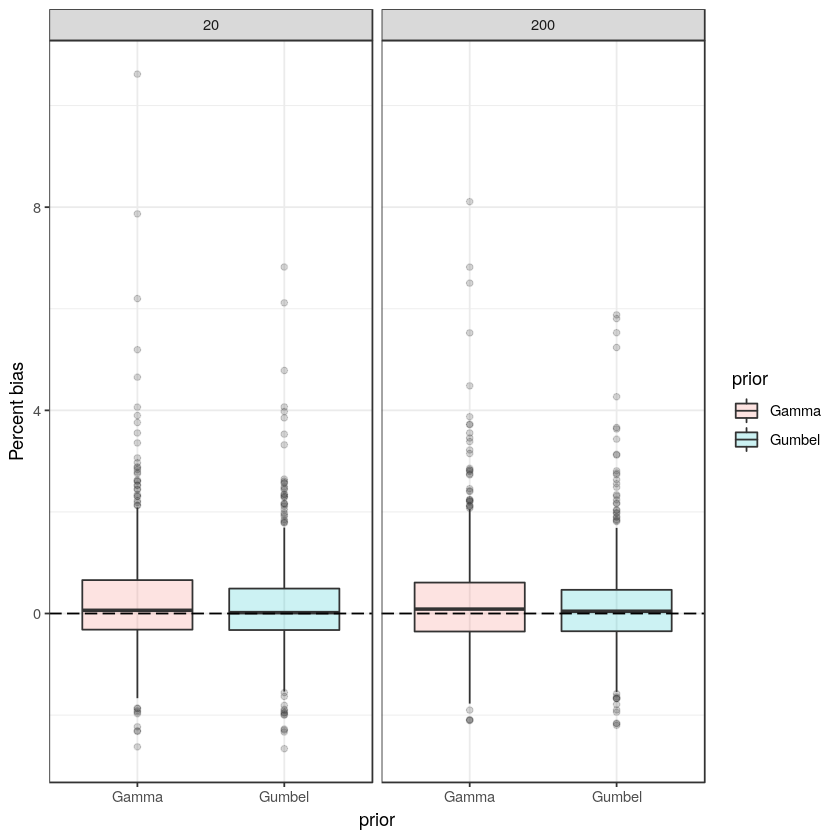

In [7]:
p0 <- ggplot(data = errors_dt, aes(x = prior, y = bias, fill= prior)) + 
  geom_boxplot(alpha = .2) +
  scale_y_continuous("Percent bias") + 
  geom_hline(yintercept = 0, linetype = "longdash") +
  facet_grid(.~ ntaxa) +
  theme_bw()
p0

In [8]:
ggsave("~/Dropbox/GENERAL_CRAP_TANK/PRIORS_BAYESIAN_PHYLOGENETICS/NOTES/figures/bias_phylodyn.pdf", plot = p0)

Saving 6.67 x 6.67 in image


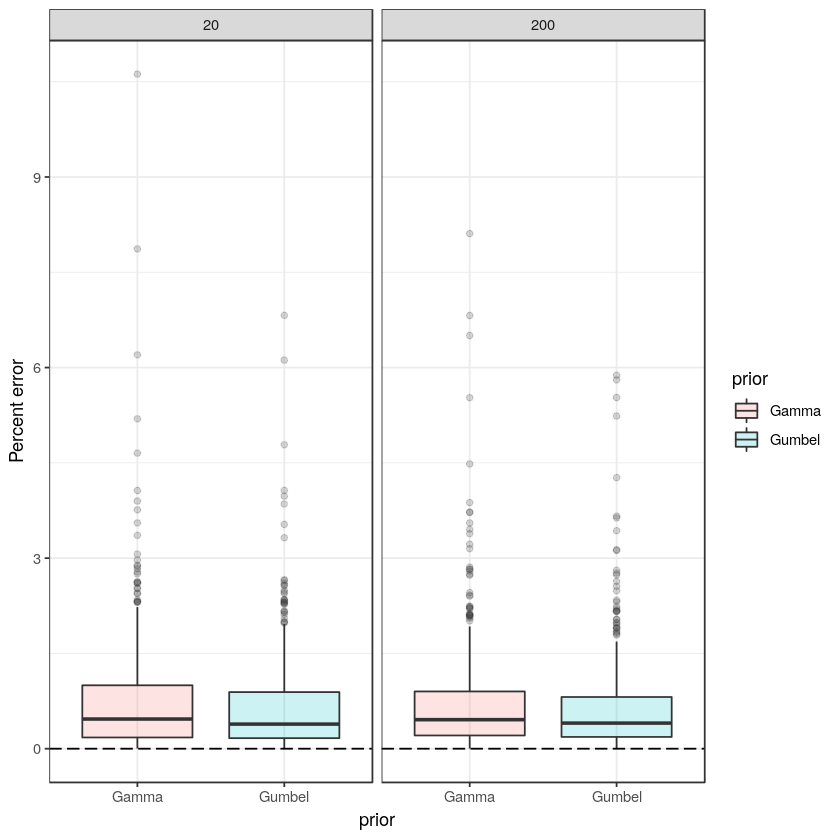

In [9]:
p0b <- ggplot(data = errors_dt, aes(x = prior, y = abs(bias), fill= prior)) + 
  geom_boxplot(alpha = .2) +
  scale_y_continuous("Percent error") + 
  geom_hline(yintercept = 0, linetype = "longdash") +
  facet_grid(.~ ntaxa) +
  theme_bw()
p0b

In [10]:
ggsave("~/Dropbox/GENERAL_CRAP_TANK/PRIORS_BAYESIAN_PHYLOGENETICS/NOTES/figures/error_phylodyn.pdf", plot = p0b)

Saving 6.67 x 6.67 in image


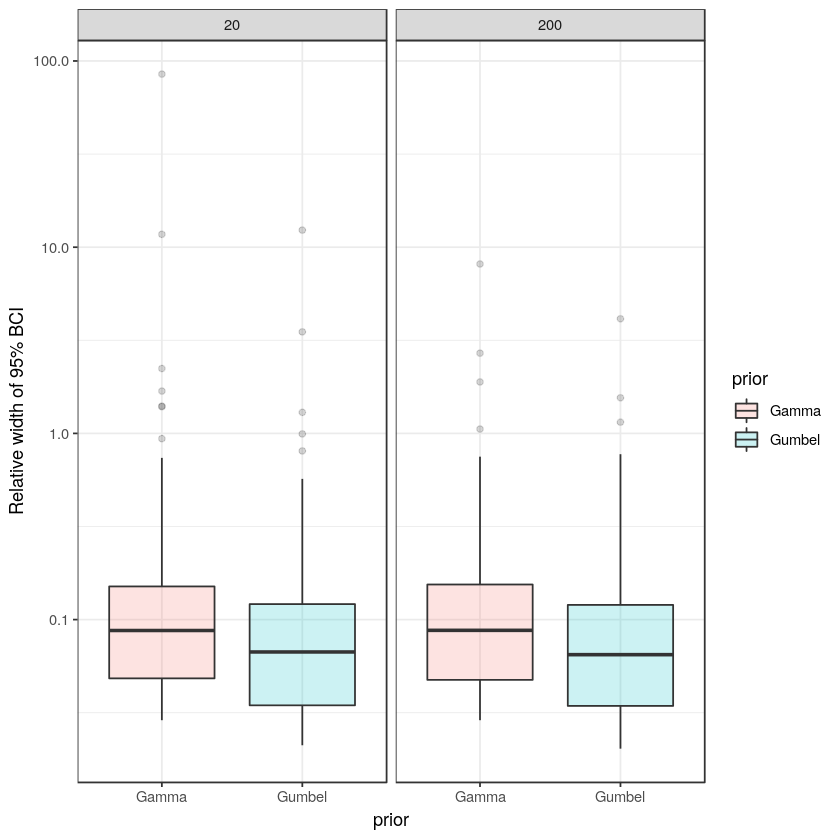

In [11]:
p1 <- ggplot(data = errors_dt, aes(x = prior, y = widths, fill= prior)) + 
  geom_boxplot(alpha = .2) +
  scale_y_log10("Relative width of 95% BCI") +
  facet_grid(.~ ntaxa) +
  theme_bw()
p1

In [29]:
aggregate(errors_dt[, c("bias", "widths")], by = list(errors_dt$ntaxa, errors_dt$prior),FUN = mean)

Group.1,Group.2,bias,widths
20,Gamma,0.2861177,0.3216843
200,Gamma,0.2497590,0.1438066
20,Gumbel,0.1694798,0.1264413
200,Gumbel,0.1411696,0.1035962


In [30]:
aggregate(errors_dt[, c("bias", "widths")], by = list(errors_dt$ntaxa, errors_dt$prior),FUN = median)

Group.1,Group.2,bias,widths
20,Gamma,0.06298942,0.08740547
200,Gamma,0.08644303,0.08757117
20,Gumbel,0.01723173,0.06701122
200,Gumbel,0.04432222,0.06481843


In [12]:
ggsave("~/Dropbox/GENERAL_CRAP_TANK/PRIORS_BAYESIAN_PHYLOGENETICS/NOTES/figures/BCI_width_phylodyn.pdf", plot = p1)

Saving 6.67 x 6.67 in image


In [13]:
summaries_gamma_20taxa <- do.call(rbind, lapply(1:nrep, function(i) {
  data.frame(reconstructions_20taxa_gamma[[i]]$summary, replicate = i, prior = "Gamma", ntaxa = "20")
} ))
summaries_gumbel_20taxa <- do.call(rbind, lapply(1:nrep, function(i) {
  data.frame(reconstructions_20taxa_gumbel[[i]]$summary, replicate = i, prior = "Gumbel", ntaxa = "20")
} ))

summaries_gamma_200taxa <- do.call(rbind, lapply(1:nrep, function(i) {
  data.frame(reconstructions_200taxa_gamma[[i]]$summary, replicate = i, prior = "Gamma", ntaxa = "200")
} ))
summaries_gumbel_200taxa <- do.call(rbind, lapply(1:nrep, function(i) {
  data.frame(reconstructions_200taxa_gumbel[[i]]$summary, replicate = i, prior = "Gumbel", ntaxa = "200")
} ))



all_estimates <- rbind(summaries_gamma_20taxa, summaries_gumbel_20taxa,
                      summaries_gamma_200taxa, summaries_gumbel_200taxa)
all_estimates$ntaxa <- as.factor(all_estimates$ntaxa)
head(all_estimates)

time,mean,sd,quant0.025,quant0.5,quant0.975,replicate,prior,ntaxa
0.2002176,7.540079,4.894529,2.282895,7.245824,32.01777,1,Gamma,20
0.6006529,7.527054,4.754979,2.360596,7.237415,30.73572,1,Gamma,20
1.0010882,7.512316,4.610748,2.442491,7.227915,29.45588,1,Gamma,20
1.4015235,7.495465,4.461252,2.528844,7.217066,28.17587,1,Gamma,20
1.8019588,7.475240,4.308428,2.617082,7.204011,26.91249,1,Gamma,20
2.2023941,7.448946,4.156061,2.701336,7.186796,25.69018,1,Gamma,20


Warning message:
“Removed 18545 rows containing missing values (geom_path).”

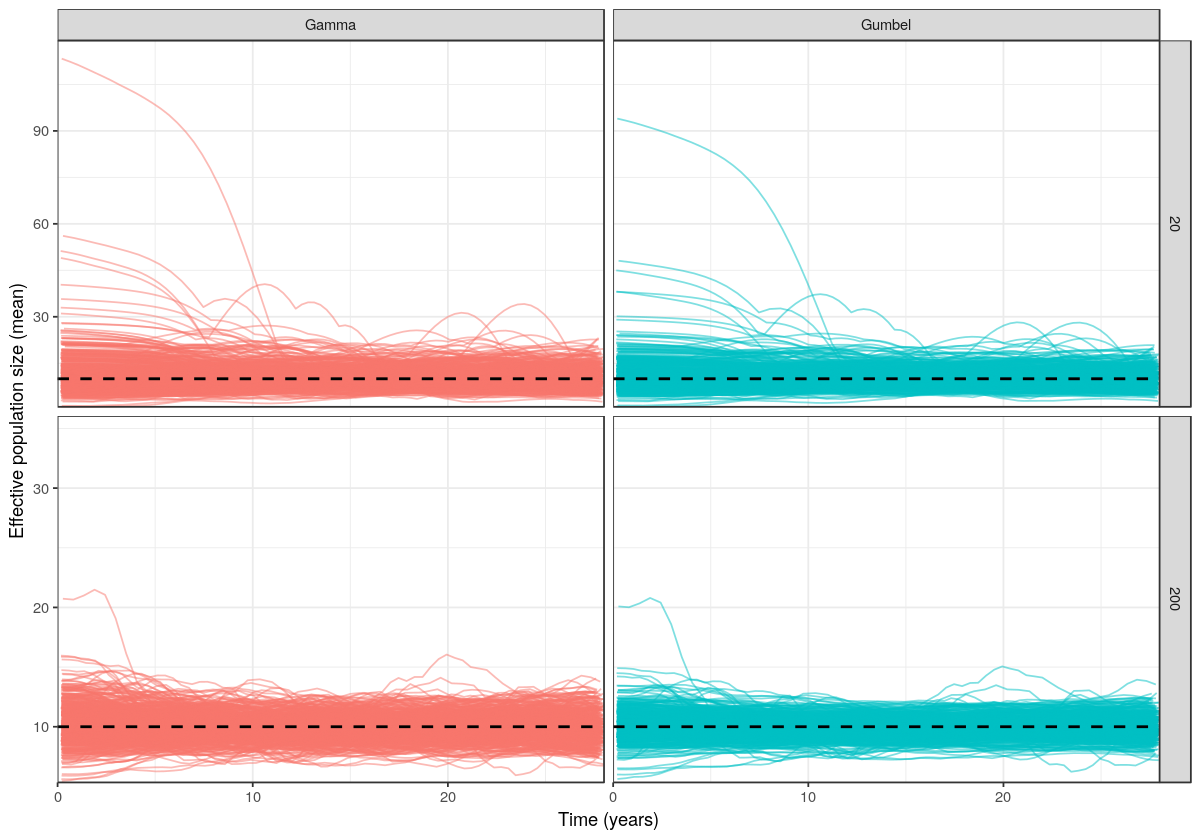

In [14]:
for_plot <- all_estimates
for_plot$replicate <- as.factor(for_plot$replicate)
options(repr.plot.width = 10, repr.plot.height = 7)
p2 <- ggplot(data = for_plot, aes(x = time, y = mean, col = prior, group = replicate)) +  
  scale_x_continuous("Time (years)", expand = c(0, 0), limits = c(0, 28)) +
  scale_y_continuous("Effective population size (mean)", expand = c(0, 0)) + 
  geom_line(alpha = .5) +
  facet_grid(ntaxa~prior, scales = "free_y") +  
  guides(col = FALSE) + 
  theme_bw() +
  geom_hline(yintercept = 10, linetype = "dashed", size = .8)+
  NULL
p2

In [18]:
ggsave("~/Dropbox/GENERAL_CRAP_TANK/PRIORS_BAYESIAN_PHYLOGENETICS/NOTES/figures/trajectories_mean_phylodyn.pdf",
       plot = p2)

Saving 6.67 x 6.67 in image
Warning message:
“Removed 18545 rows containing missing values (geom_path).”

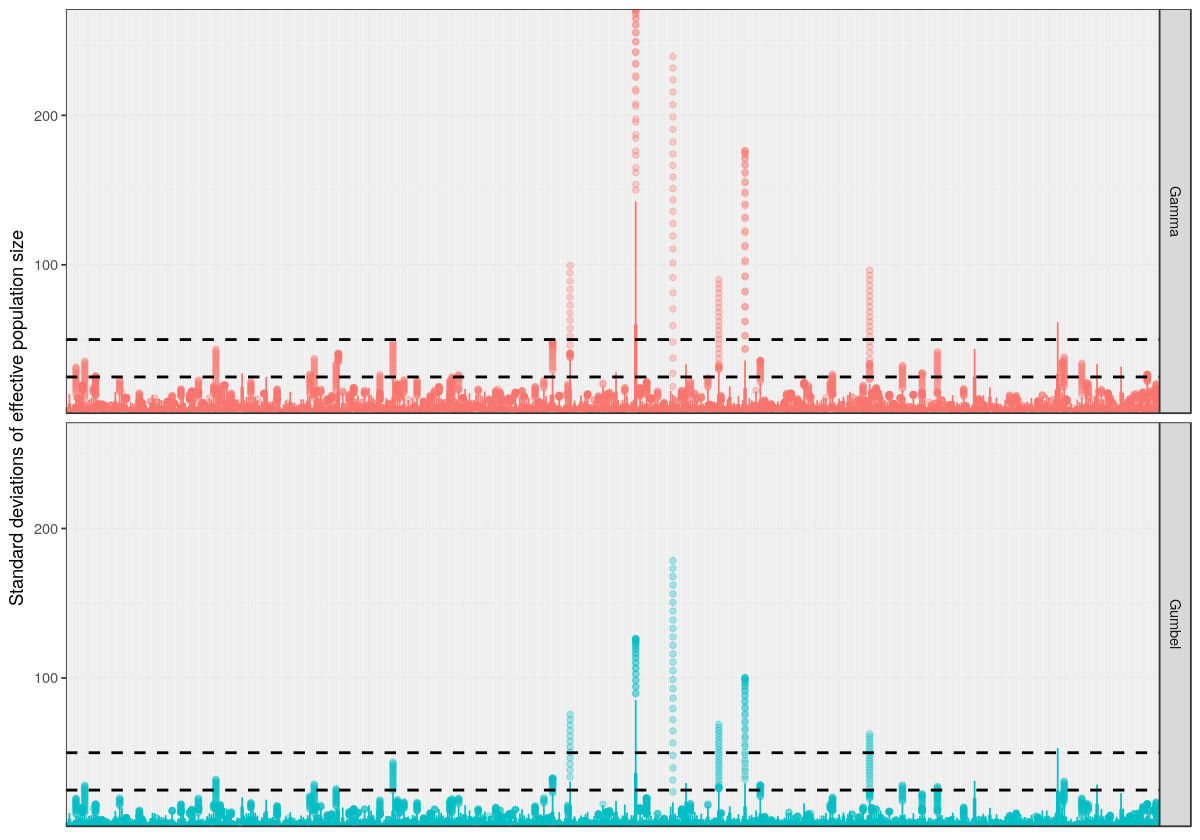

In [16]:
p3 <- ggplot(data = for_plot, aes(x = replicate, y = sd, col = prior)) + 
  geom_boxplot(alpha = .3) +
  scale_y_continuous("Standard deviations of effective population size", expand = c(0, 0)) + 
  facet_grid(prior~.) +
  guides(col = FALSE) + 
  geom_hline(yintercept = 25, linetype = "dashed", size = .8) +
  geom_hline(yintercept = 50, linetype = "dashed", size = .8) +
  theme_bw() +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank()) +
  NULL
p3

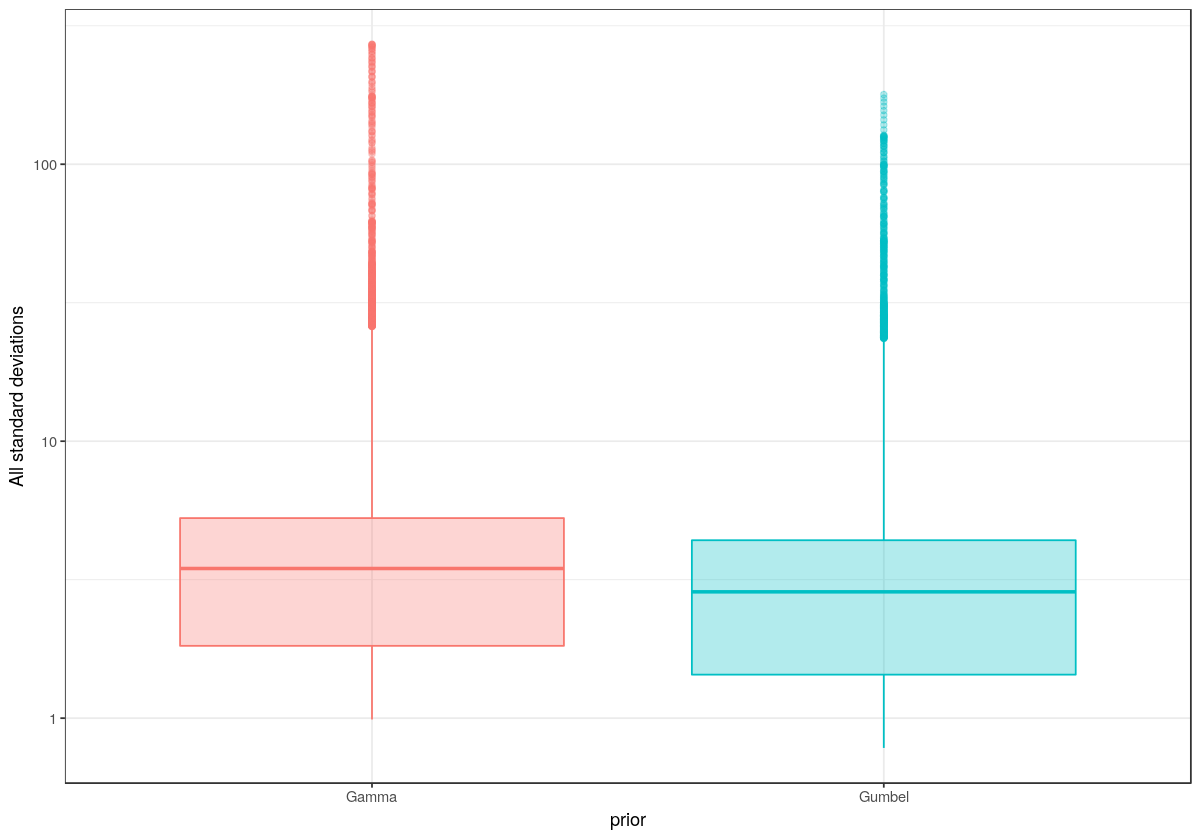

In [17]:
p4 <- ggplot(data = for_plot, aes(x = prior, y = sd, col = prior, fill = prior)) + 
  geom_boxplot(alpha = .3) +
  scale_y_log10("All standard deviations") + 
  guides(col = FALSE) + 
  guides(fill = FALSE) + 
  theme_bw() +
  NULL
p4

In [33]:
aggregate(for_plot[, c("mean", "sd")], by = list(for_plot$ntaxa, for_plot$prior), FUN = mean)

Group.1,Group.2,mean,sd
20,Gamma,11.39803,6.488466
200,Gamma,10.23448,2.540332
20,Gumbel,10.97499,5.368083
200,Gumbel,10.09285,1.830516


In [38]:
aggregate(for_plot[, c("mean", "sd")], by = list(for_plot$ntaxa, for_plot$prior), FUN = median)

Group.1,Group.2,mean,sd
20,Gamma,10.51325,4.896081
200,Gamma,10.01149,1.827847
20,Gumbel,10.32727,4.266921
200,Gumbel,10.01329,1.436259
